<a href="https://colab.research.google.com/github/xuebingwu/SplicingScan/blob/main/splicingScan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <font color='MediumSlateBlue '> **Splicing^Scan**  </font> 
## A Colab notebook for discovering splice sites and regulatory elements from a single sequence
---
[Xuebing Wu lab @ Columbia](https://xuebingwu.github.io/)     |     [GitHub repository](https://github.com/xuebingwu/splice-site-prediction-with-pangolin) 




2023-05-10 21:05:15: Loading Pangolin (~30s, first time only)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Cloning into 'SplicingScan'...
remote: Enumerating objects: 772, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 772 (delta 131), reused 152 (delta 112), pack-reused 583
Receiving objects: 100% (772/772), 193.79 MiB | 20.93 MiB/s, done.
Resolving deltas: 100% (410/410), done.
Updating files: 100% (54/54), done.
/content/SplicingScan
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/SplicingScan
  Preparing metadata (setup.py) ... done
  Created wheel for pangolin: filename=pangolin-1.0.2-py3-none-any.whl size=104923074 sha256=be20550a67a0e9580ba38f433bbf9b56454f3e3ffa875c3da025050a60aa3420
  Stored in directory: /tmp/pip-ephem-wheel-cache-wew9gzto/wheels/13/26/7b/bd8af976b6c765ca2184a963b48c9dfb750bc07a3c32a30d45
Successfully

/content
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


OUTPUT


2023-05-10 21:05:45: Input sequence length = 2329
2023-05-10 21:05:45: Loading models
GPU not available!!
GPU not available!!
GPU not available!!
GPU not available!!
GPU not available!!
2023-05-10 21:05:45: Scoring sites: + strand
2023-05-10 21:05:49: Filtering sites: + strand
4 splice sites found on the + strand with SCORE_CUTOFF = 0.2
2023-05-10 21:05:49: Saving to file: + strand

---------------------------------
#Predicted splice sites
#Options: SCORE_TYPE=Usage, SCORE_CUTOFF=0.2
#Columns info:
#1 - Position: site position in the sequence
#2 - Sequence: 20-nt junction sequence. Intron-lower case; Exon-upper case
#3 - Strand: strand of the site
#4 - Type: 5' splice site (5'SS), 3' splice site (3'SS), or 3'SS(likely), or Noncanonical
#5-8 - Scores: site usage or P(splice) in each tissue

Position	Sequence	Strand	Type	Testis
130	CCTCGTCGCAGgtacttgag	+	5'SS	0.663
968	CCCGTTACAGAGTCACCATC	+	3'SS(likely)	0

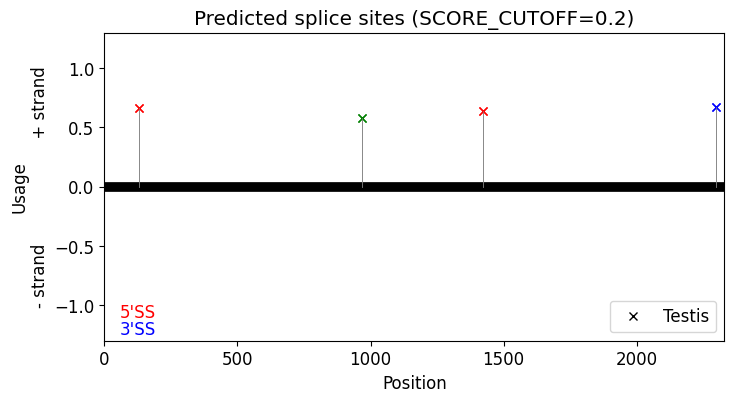

In [ ]:
#@title Step 1: Predict splice sites

# scripts from custom_usage.py from the Pangolin package

import os
from matplotlib import pylab
import matplotlib.lines as mlines
from google.colab import files
import datetime
import re
from tqdm.notebook import tqdm 

######### options

########## input 
INPUT = "MAPT exon 10"#@param ["Paste your sequence or select a sample sequence (default: SRSF3 skipped exon)","GAPDH pre-mRNA", "EGFP + CENPB 3' UTR reporter","SMN2 exon 7","MAPT exon 10"] {allow-input: true}
#INPUT = "Paste your sequence or select a sample sequence (default: ACTB pre-mRNA)"#@param ["ACTB pre-mRNA", "GAPDH pre-mRNA", "EGFP + CENPB 3' UTR reporter"] {allow-input: true}

#@markdown - To run: click `Runtime` -> `Run all` in the menu bar, or click the triangle play/run button on the left
#@markdown - Input format: raw sequence (A/C/G/T/U only); space allowed
#@markdown - Multi-line sequence from a FASTA file (without the header) can be copy-pasted directly
#@markdown - Sample sequences can be selected from the dropdown box

# set model type
SCORE_TYPE = "Usage" #@param ["Usage", "P(splice)"]
#@markdown - *Usage*: predict tissue-specific usage of a splice site (default).  
#@markdown - *P(splice)*: predict tissue-specific probability of a site being spliced
#@markdown - The model trained with testis data is used as it is the most sensititive one.

if SCORE_TYPE == "Usage":
  model_nums = [7]
else:
  model_nums = [6]
# 0 = Heart, P(splice)
# 1 = Heart, usage
# 2 = Liver, P(splice)
# 3 = Liver, usage
# 4 = Brain, P(splice)
# 5 = Brain, usage
# 6 = Testis, P(splice)
# 7 = Testis, usage

tissues = ['Testis']

# min score
SCORE_CUTOFF = 0.2 #@param {type:"slider", min:0.01, max:1, step:0.01}
#@markdown - Minimum usage/splicing probability of a site to be included in the output 
#@markdown - All splice sites passing this filter will be used in step 2 for regulatory elements scanning

if not os.path.exists("SplicingScan"):
  print("\n")
  print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")+': Loading Pangolin (~30s, first time only)')
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  #!pip install pyvcf gffutils biopython pandas pyfastx
  !git clone https://github.com/xuebingwu/SplicingScan.git
  %cd SplicingScan
  !pip install .
  %cd /content
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

from pkg_resources import resource_filename
from pangolin.model import *

import sys
sys.path.append('/content/SplicingScan/')
from splicingScan import *

## start the analysis


seq = INPUT
if seq == "MAPT exon 10":
  seq = "TCCTTCCCAGGTGAACCTCCAAAATCAGGGGATCGCAGCGGCTACAGCAGCCCCGGCTCCCCAGGCACTCCCGGCAGCCGCTCCCGCACCCCGTCCCTTCCAACCCCACCCACCCGGGAGCCCAAGAAGGTGGCAGTGGTCCGTACTCCACCCAAGTCGCCGTCTTCCGCCAAGAGCCGCCTGCAGACAGCCCCCGTGCCCATGCCAGACCTGAAGAATGTCAAGTCCAAGATCGGCTCCACTGAGAACCTGAAGCACCAGCCGGGAGGCGGGAAGGTGAGAGTGGCTGGCTGCGCGTGGAGGTGTGGGGGGCTGCGCCTGGAGGGGTAGGGCTGTGCCTGGAAGGGTAGGGCTGCGCCTGGAGGTGCGCGGTTGAGCGTGGAGTCGTGGGACTGTGCATGGAGGTGTGGGGCTCCCCGCACCTGAGCACCCCCGCATAACACCCCAGTCCCCTCTGGACCCTCTTCAAGGAAGTTCAGTTCTTTATTGGGCTCTCCACTACACTGTGAGTGCCCTCCTCAGGCGAGAGAACGTTCTGGCTCTTCTCTTGCCCCTTCAGCCCCTGTTAATCGGACAGAGATGGCAGGGCTGTGTCTCCACGGCCGGAGGCTCTCATAGTCAGGGCACCCACAGCGGTTCCCCACCTGCCTTCTGGGCAGAATACACTGCCACCCATAGGTCAGCATCTCCACTCGTGGGCCATCTGCTTAGGTTGGGTTCCTCTGGATTCTGGGGAGATTGGGGGTTCTGTTTTGATCAGCTGATTCTTCTGGGAGCAAGTGGGTGCTCGCGAGCTCTCCAGCTTCCTAAAGGTGGAGAAGCACAGACTTCGGGGGCCTGGCCTGGATCCCTTTCCCCATTCCTGTCCCTGTGCCCCTCGTCTGGGTGCGTTAGGGCTGACATACAAAGCACCACAGTGAAAGAACAGCAGTATGCCTCCTCACTAGCCAGGTGTGGGCGGGTGGGTTTCTTCCAAGGCCTCTCTGTGGCCGTGGGTAGCCACCTCTGTCCTGCACCGCTGCAGTCTTCCCTCTGTGTGTGCTCCTGGTAGCTCTGCGCATGCTCATCTTCTTATAAGAACACCATGGCAGCTGGGCGTAGTGGCTCACGCCTATAATCCCAGCACTTTGGGAGGCTGAGGCAGGCAGATCACGAGGTCAGGAGTTCGAGACCAACCTGACCAACAGGGTGAAACCTCGTCTCTACTAAAAATACAAAAATACCTGGGCGTGGTGGTGGTGCGCGCCTATAATCCCAGCTACTCAGGAGGCTGAGGCAGGAGAATCGCTTGAACCCAGGAGGCAGAGGTTGCAGTGAGCCGAGATAGTGCCACTGCACTCCAGTTTGAGCAACAGAGCGAGACTCTGTCTCAAAACAAAATAAAACAAACCAAAAAAACCCACCATGGCTTAGGGCCCAGCCTGATGACCTCATTTTTCACTTAGTCACCTCTCTAAAGGCCCTGTCTCCAAATAGAGTCACATTCTAAGGTACGGGGGTGTTGGGGAGGGGGGTTAGGGCTTCAACATGTGAATTTGCGGGGACCACAATTCAGCCCAGGACCCCGCTCCCGCCACCCAGCACTGGGGAGCTGGGGAAGGGTGAAGAGGAGGCTGGGGGTGAGAAGGACCACAGCTCACTCTGAGGCTGCAGATGTGCTGGGCCTTCTGGGCACTGGGCCTCGGGGAGCTAGGGGGCTTTCTGGAACCCTGGGCCTGCGTGTCAGCTTGCCTCCCCCACGCAGGCGCTCTCCACACCATTGAAGTTCTTATCACTTGGGTCTGAGCCTGGGGCATTTGGACGGAGGGTGGCCACCAGTGCACATGGGCACCTTGCCTCAAACCCTGCCACCTCCCCCCACCCAGGATCCCCCCTGCCCCCGAACAAGCTTGTGAGTGCAGTGTCACATCCCATCGGGATGGAAATGGACGGTCGGGTTAAAAGGGACGCATGTGTAGACCCTGCCTCTGTGCATCAGGCCTCTTTTGAGAGTCCCTGCGTGCCAGGCGGTGCACAGAGGTGGAGAAGACTCGGCTGTGCCCCAGAGCACCTCCTCTCATCGAGGAAAGGACAGACAGTGGCTCCCCTGTGGCTGTGGGGACAAGGGCAGAGCTCCCTGGAACACAGGAGGGAGGGAAGGAAGAGAACATCTCAGAATCTCCCTCCTGATGGCAAACGATCCGGGTTAAATTAAGGTCCGGCCTTTTCCTGCTCAGGCATGTGGAGCTTGTAGTGGAAGAGGCTCTCTGGACCCTCATCCACCACAGTGGCCTGGTTAGAGACCTTGGGGAAATAACTCACAGGTGACCCAGGGCCTCTGTCCTGTACCGCAGCTGAGGGAAACTGTCCTGCGCTTCCACTGGGGACAATGCGCTCCCTCGTCTCCAGACTTTCCAGTCCTCATTCGGTTCTCGAAAGTCGCCTCCAGAAGCCCCATCTTGGGACCACCGTGACTTTCATTCTCCAGGGTGCCTGGCCTTGGTGCTGCCCAAGACCCCAGAGGGGCCCTCACTGGCCTTTCCTGCCTTTTCTCCCATTGCCCACCCATGCACCCCCATCCTGCTCCAGCACCCAGACTGCCATCCAGGATCTCCTCAAGTCACATAACAAGCAGCACCCACAAGGTGCTCCCTTCCCCCTAGCCTGAATCTGCTGCTCCCCGTCTGGGGTTCCCCGCCCATGCACCTCTGGGGGCCCCTGGGTTCTGCCATACCCTGCCCTGTGTCCCATGGTGGGGAATGTCCTTCTCTCCTTATCTCTTCCCTTCCCTTAAATCCAAGTTCAGTTGCCATCTCCTCCAGGAAGTCTTCCTGGATTCCCCTCTCTCTTCTTAAAGCCCCTGTAAACTCTGACCACACTGAGCATGTGTCTGCTGCTCCCTAGTCTGGGCCATGAGTGAGGGTGGAGGCCAAGTCTCATGCATTTTTGCAGCCCCCACAAGACTGTGCAGGTGGCCGGCCCTCATTGAATGCGGGGTTAATTTAACTCAGCCTCTGTGTGAGTGGATGATTCAGGTTGCCAGAGACAGAACCCTCAGCTTAGCATGGGAAGTAGCTTCCCTGTTGACCCTGAGTTCATCTGAGGTTGGCTTGGAAGGTGTGGGCACCATTTGGCCCAGTTCTTACAGCTCTGAAGAGAGCAGCAGGAATGGGGCTGAGCAGGGAAGACAACTTTCCATTGAAGGCCCCTTTCAGGGCCAGAACTGTCCCTCCCACCCTGCAGCTGCCCTGCCTCTGCCCATGAGGGGTGAGAGTCAGGCGACCTCATGCCAAGTGTAGAAAGGGGCAGATGGGAGCCCCAGGTTATGACGTCACCATGCTGGGTGGAGGCAGCACGTCCAAATCTACTAAAGGGTTAAAGGAGAAAGGGTGACTTGACTTTTCTTGAGATATTTTGGGGGACGAAGTGTGGAAAAGTGGCAGAGGACACAGTCACAGCCTCCCTTAAATGCCAGGAAAGCCTAGAAAAATTGTCTGAAACTAAACCTCAGCCATAACAAAGACCAACACATGAATCTCCAGGAAAAAAGAAAAAGAAAAATGTCATACAGGGTCCATGCACAAGAGCCTTTAAAATGACCCGCTGAAGGGTGTCAGGCCTCCTCCTCCTGGACTGGCCTGAAGGCTCCACGAGCTTTTGCTGAGACCTTTGGGTCCCTGTGGCCTCATGTAGTACCCAGTATGCAGTAAGTGCTCAATAAATGTTTGGCTACAAAAGAGGCAAAGCTGGCGGAGTCTGAAGAATCCCTCAACCGTGCCGGAACAGATGCTAACACCAAAGGGAAAAGAGCAGGAGCCAAGTCACGTTTGGGAACCTGCAGAGGCTGAAAACTGCCGCAGATTGCTGCAAATCATTGGGGGAAAAACGGAAAACGTCTGTTTTCCCCTTTGTGCTTTTCTCTGTTTTCTTCTTTGTGCTTTTCTCTGTTTTCAGGATTTGCTACAGTGAACATAGATTGCTTTGGGGCCCCAAATGGAATTATTTTGAAAGGAAAATGCAGATAATCAGGTGGCCGCACTGGAGCACCAGCTGGGTAGGGGTAGAGATTGCAGGCAAGGAGGAGGAGCTGGGTGGGGTGCCAGGCAGGAAGAGCCCGTAGGCCCCGCCGATCTTGTGGGAGTCGTGGGTGGCAGTGTTCCCTCCAGACTGTAAAAGGGAGCACCTGGCGGGAAGAGGGAATTCTTTTAAACATCATTCCAGTGCCCGAGCCTCCTGGACCTGTTGTCATCTTGAGGTGGGCCTCCCCTGGGTGACTCTAGTGTGCAGCCTGGCTGAGACTCAGTGGCCCTGGGTTCTTACTGCTGACACCTACCCTCAACCTCAACCACTGCGGCCTCCTGTGCACCCTGATCCAGTGGCTCATTTTCCACTTTCAGTCCCAGCTCTATCCCTATTTGCAGTTTCCAAGTGCCTGGTCCTCAGTCAGCTCAGACCCAGCCAGGCCAGCCCCTGGTTCCCACATCCCCTTTGCCAAGCTCATCCCCGCCCTGTTTGGCCTGCGGGAGTGGGAGTGTGTCCAGACACAGAGACAAAGGACCAGCTTTTAAAACATTTTGTTGGGGCCAGGTGTGGTGGCTCACACCTAATCCCAACACCTGGGGAGGCCAAGGCAGAAGGATCACTTGAGTCCAGGAGTTCAAGACCAGCCTGGGCAACATAGGGAGACCCTGTCTCTACAATTTTTTTTTTAATTAGCTGGGCCTGTTGGCACTCTCCTGTAGTTCCAGCTACTCTAGAGGCTGAGGTGGGAGGACTGCTTGAGCCTGGGAGGTCAGGGCTGCAATGAGCCATGTTCACACCACTGAACGCCAGCCTGGGCGAGACCCTGTATCAAAAAAGTAAAGTAAAATGAATCCTGTACGTTATATTAAGGTGCCCCAAATTGTACTTAGAAGGATTTCATAGTTTTAAATACTTTTGTTATTTAAAAAATTAAATGACTGCAGCATATAAATTAGGTTCTTAATGGAGGGGAAAAAGAGTACAAGAAAAGAAATAAGAATCTAGAAACAAAGATAAGAGCAGAAATAAACCAGAAAACACAACCTTGCACTCCTAACTTAAAAAAAAAAATGAAGAAAACACAACCAGTAAAACAACATATAACAGCATTAAGAGCTGGCTCCTGGCTGGGCGCGGTGGCGCATGCCTGTAATCCCAACACTTTGGGAGGCCGATGCTGGAGGATCACTTGAGACCAGGAGTTCAAGGTTGCAGTGAGCTATGATCATACCACTACACCCTAGCCTGGGCAACACAGTGAGACTGAGACTCTATTAAAAAAAAAATGCTGGTTCCTTCCTTATTTCATTCCTTTATTCATTCATTCAGACAACATTTATGGGGCACTTCTGAGCACCAGGCTCTGTGCTAAGAGCTTTTGCCCCCAGGGTCCAGGCCAGGGGACAGGGGCAGGTGAGCAGAGAAACAGGGCCAGTCACAGCAGCAGGAGGAATGTAGGATGGAGAGCTTGGCCAGGCAAGGACATGCAGGGGGAGCAGCCTGCACAAGTCAGCAAGCCAGAGAAGACAGGCAGACCCTTGTTTGGGACCTGTTCAGTGGCCTTTGAAAGGACAGCCCCCACCCGGAGTGCTGGGTGCAGGAGCTGAAGGAGGATAGTGGAACACTGCAACGTGGAGCTCTTCAGAGCAAAAGCAAAATAAACAACTGGAGGCAGCTGGGGCAGCAGAGGGTGTGTGTTCAGCACTAAGGGGTGTGAAGCTTGAGCGCTAGGAGAGTTCACACTGGCAGAAGAGAGGTTGGGGCAGCTGCAAGCCTCTGGACATCGCCCGACAGGACAGAGGGTGGTGGACGGTGGCCCTGAAGAGAGGCTCAGTTCAGCTGGCAGTGGCCGTGGGAGTGCTGAAGCAGGCAGGCTGTCGGCATCTGCTGGGGACGGTTAAGCAGGGGTGAGGGCCCAGCCTCAGCAGCCCTTCTTGGGGGGTCGCTGGGAAACATAGAGGAGAACTGAAGAAGCAGGGAGTCCCAGGGTCCATGCAGGGCGAGAGAGAAGTTGCTCATGTGGGGCCCAGGCTGCAGGATCAGGAGAACTGGGGACCCTGTGACTGCCAGCGGGGAGAAGGGGGTGTGCAGGATCATGCCCAGGGAAGGGCCCAGGGGCCCAAGCATGGGGGGGCCTGGTTGGCTCTGAGAAGATGGAGCTAAAGTCACTTTCTCGGAGGATGTCCAGGCCAATAGTTGGGATGTGAAGACGTGAAGCAGCACAGAGCCTGGAAGCCCAGGATGGACAGAAACCTACCTGAGCAGTGGGGCTTTGAAAGCCTTGGGGCGGGGGGTGCAATATTCAAGATGGCCACAAGATGGCAATAGAATGCTGTAACTTTCTTGGTTCTGGGCCGCAGCCTGGGTGGCTGCTTCCTTCCCTGTGTGTATTGATTTGTTTCTCTTTTTTGAGACAGAGTCTTGCTGGGTTGCCCAGGCTGGAGTGCAGTGGTGCGATCATAGCTCACTGCAGCCTTGAAGTCCTGAGCTCAAGAGATCCTTCCACCTCAGCCTCCTGAGTAGTTGGGACCACAGGCTTGCACCACAGTGCCCAACTAATTTCTTATATTTTTTGTAGAGATGGGGTTTCACTGTGTCGCCCAGGATGGTCTTGAACTCCTGGGCTCAAGTGATCCTCCTGCCTCAGCCTCGCAAATTGCTGGGATTACAGGTGTGAGCCACCATGCCCGACCTTCTCTTTTTAAGGGCGTGTGTGTGTGTGTGTGTGTGTGGGCGCACTCTCGTCTTCACCTTCCCCCAGCCTTGCTCTGTCTCTACCCAGTCACCTCTGCCCATCTCTCCGATCTGTTTCTCTCTCCTTTTACCCCTCTTTCCTCCCTCCTCATACACCACTGACCATTATAGAGAACTGAGTATTCTAAAAATACATTTTATTTATTTATTTTGAGACAGAGTCTCACTCTGTCACCCAGGCTGGAGTGCAGTGGTGCAATCTCGGCTCACTGCAACCTCCGCCTCCCAGGTTGAAGCAACTCTCCTGCCTCAGCCTCCCTAGTAGCTGGGATTACAAGCACACACCACCATGCCTAGCAAATTTTTATATTTTTAGTAGAGGAGGGGTGTCACCATGTTTGCCAAGCTGGTCTCAAACTCCTGGCCTCAGGTGATCTGCCTACCTTGGTCTCCCAAAGTGCTGGGATTACAGGTGTGAGCCACCACGCCTGCCCTTAAAAATACATTATATTTAATAGCAAAGCCCCAGTTGTCACTTTAAAAAGCATCTATGTAGAACATTTATGTGGAATAAATACAGTGAATTTGTACGTGGAATCGTTTGCCTCTCCTCAATCAGGGCCAGGGATGCAGGTGAGCTTGGGCTGAGATGTCAGACCCCACAGTAAGTGGGGGGCAGAGCCAGGCTGGGACCCTCCTCTAGGACAGCTCTGTAACTCTGAGACCCTCCAGGCATCTTTTCCTGTACCTCAGTGCTTCTGAAAAATCTGTGTGAATCAAATCATTTTAAAGGAGCTTGGGTTCATCACTGTTTAAAGGACAGTGTAAATAATTCTGAAGGTGACTCTACCCTGTTATTTGATCTCTTCTTTGGCCAGCTGACTTAACAGGACATAGACAGGTTTTCCTGTGTCAGTTCCTAAGCTGATCACCTTGGACTTGAAGAGGAGGCTTGTGTGGGCATCCAGTGCCCACCCCGGGTTAAACTCCCAGCAGAGTATTGCACTGGGCTTGCTGAGCCTGGTGAGGCAAAGCACAGCACAGCGAGCACCAGGCAGTGCTGGAGACAGGCCAAGTCTGGGCCAGCCTGGGAGCCAACTGTGAGGCACGGACGGGGCTGTGGGGCTGTGGGGCTGCAGGCTTGGGGCCAGGGAGGGAGGGCTGGGCTCTTTGGAACAGCCTTGAGAGAACTGAACCCAAACAAAACCAGATCAAGGTCTAGTGAGAGCTTAGGGCTGCTTTGGGTGCTCCAGGAAATTGATTAAACCAAGTGGACACACACCCCCAGCCCCACCTCACCACAGCCTCTCCTTCAGGGTCAAACTCTGACCACAGACATTTCTCCCCTGACTAGGAGTTCCCTGGATCAAAATTGGGAGCTTGCAACACATCGTTCTCTCCCTTGATGGTTTTTGTCAGTGTCTATCCAGAGCTGAAGTGTAATATATATGTTACTGTAGCTGAGAAATTAAATTTCAGGATTCTGATTTCATAATGACAACCATTCCTCTTTTCTCTCCCTTCTGTAAATCTAAGATTCTATAAACGGTGTTGACTTAATGTGACAATTGGCAGTAGTTCAGGTCTGCTTTGTAAATACCCTTGTGTCTATTGTAAAATCTCACAAAGGCTTGTTGCCTTTTTTGTGGGGTTAGAACAAGAAAAAGCCACATGGAAAAAAAATTTCTTTTTTGTTTTTTTGTTTGCTTGTTTTTTTGAGACAGAGTTTCACTCTGTCGCCCAGGCTGGAGTGCAGTGGTGCGATCTCCGCCCACTGCAAGCTCCACCTCCCGGGTTCATGCTATTCTCCTGTCTCAGCCTCCCAAGTAGCTGGGACTGCAGGTGCCCGCCACCACACCTGGCTAATTTTTTTGTATTTTTAGTAGAGACGGGGTTTCACCGTGTTAGCCAGGATGGTCTCAATCTCCTGACCTCGTCATCTGCCTGCCTCGGCCTCCCAAAGTGCTGAGATTACAGGCGTGAGCCACCGTGCCCGGCCAGAAAAAAACATTTCTAAGTATGTGGCAGATACTGAATTATTGCTTAATGTCCTTTGATTCATTTGTTTAATTTCTTTAATGGATTAGTACAGAAAACAAAGTTCTCTTCCTTGAAAAACTGGTAAGTTTTCTTTGTCAGATAAGGAGAGTTAAATAACCCATGACATTTCCCTTTTTGCCTCGGCTTCCAGGAAGCTCAAAGTTAAATGTAATGATCACTCTTGTAATTATCAGTGTTGATGCCCTTCCCTTCTTCTAATGTTACTCTTTACATTTTCCTGCTTTATTATTGTGTGTGTTTTCTAATTCTAAGCTGTTCCCACTCCTTTCTGAAAGCAGGCAAATCTTCTAAGCCTTATCCACTGAAAAGTTATGAATAAAAAATGATCGTCAAGCCTACAGGTGCTGAGGCTACTCCAGAGGCTGAGGCCAGAGGACCACTTGAGCCCAGGAATTTGAGACCTGGGCTGGGCAGCATAGCAAGACTCTATCTCCATTAAAACTATTTTTTTTTATTTAAAAAATAATCCGCAAAGAAGGAGTTTATGTGGGATTCCTTAAAATCGGAGGGTGGCATGAATTGATTCAAAGACTTGTGCAGAGGGCGACAGTGACTCCTTGAGAAGCAGTGTGAGAAAGCCTGTCCCACCTCCTTCCGCAGCTCCAGCCTGGGCTGAGGCACTGTCACAGTGTCTCCTTGCTGGCAGGAGAGAATTTCAACATTCACCAAAAAGTAGTATTGTTTTTATTAGGTTTATGAGGCTGTAGCCTTGAGGACAGCCCAGGACAACTTTGTTGTCACATAGATAGCCTGTGGCTACAAACTCTGAGATCTAGATTCTTCTGTGGCTGCTTCTGACCTGAGAAAGTTGCGGAACCTCAGCGAGCCTCACATGGCCTCCTTGTCCTTAACGTGGGGACGGTGGGCAAGAAAGGTGATGTGGCACTAGAGATTTATCCATCTCTAAAGGAGGAGTGGATTGTACATTGAAACACCAGAGAAGGAATTACAAAGGAAGAATTTGAGTATCTAAAAATGTAGGTCAGGCGCTCCTGTGTTGATTGCAGGGCTATTCACAATAGCCAAGATTTGGAAGCAACCCAAGTGTCCATCAACAGACAAATGGATAAAGAAAATGTGGTGCATATACACAATGGAATACTATTCAGCCATGAAAAAGAATGAGAATCTGTCATTTGAAACAACATGGATGGAACTGGAGGACATTATGTTAAGTGAAATAAGCCAGACAGAAGGACAGACTTCACATGTTCTCACACATTTGTGGGAGCTAAAAATTAAACTCATGGAGATAGAGAGTAGAAGGATGGTTACCAGAGGCTGAGGAGGGTGGAGGGGAGCAGGGAGAAAGTAGGGATGGTTAATGGGTACAAAAACGTAGTTAGCATGCATAGATCTAGTATTGGATAGCACAGCAGGGTGACGACAGCCAACAGTAATTTATAGTACATTTAAAAACAACTAAAAGAGTGTAATTGGACTGGCTAACATGGTGAAACCCCGTCTCTACTAAAAATACAAAAATTAGCTGGGCATGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCGAGGCGGGCCGATCACGAGGTCAGGAGATCGAGACCATCCTAGCTAACATGGTGAAACCCCGTCTCTACTACAAATACAAAAAAAAGAAAAAATTAGCCGGGCATGGTGGTGGGCGCCTGTAGTCCCAGCTACTCGGGAGGCTGAGGCAGGAGAATGGCGTGAACCCGGGAGGCGGAGCTTGCAGTGAGCCGAGATCGCGCCACTGCACTCCAGCCTGGGCGACAAGGCAAGATTCTATCTCAAAAAAATAAAAATAAAATAAAATAAAATAATAAAATAAAATAAAATAAAATAAAATAAATAAAATAAAATAAAATGTATAATTGGAATGTTTATAACACAAGAAATGATAAATGCTTGAGGTGATAGATACCCCATTCACCGTGATGTGATTATTGCACAATGTATGTCTGTATCTAAATATCTCATGTACCCCACAAGTATATACACCTACTATGTACCCATATAAATTTAAAATTAAAAAATTATAAAACAAAAATAAATAAGTAAATTAAAATGTAGGCTGGACACCGTGGTTCACGCCTGTAATCCCAGTGCTTTGTGAGGCTGAGGTGAGAGAATCACTTGAGCCCAGGAGTTTGAGACCGGCCTGGGTGACATAGCGAGACCCCATCATCACAAAGAATTTTTAAAAATTAGCTGGGCGTGGTAGCACATACCGGTAGTTCCAGCTACTTGGGAGACCGAGGCAGGAGGATTGCTTGAGCCCAGGAGTTTAAGGCTGCAGTGAGCTACGATGGCGCCACTGCATTCCAGCCTGGGTGACAGAGTGAGAGCTTGTCTCTATTTTAAAAATAATAAAAAGAATAAATAAAAATAAATTAAAATGTAAATATGTGCATGTTAGAAAAAATACACCCATCAGCAAAAAGGGGGTAAAGGAGCGATTTCAGTCATAATTGGAGAGATGCAGAATAAGCCAGCAATGCAGTTTCTTTTATTTTGGTCAAAAAAAATAAGCAAAACAATGTTGTAAACACCCAGTGCTGGCAGCAATGTGGTGAGGCTGGCTCTCTCACCAGGGCTCACAGGGAAAACTCATGCAACCCTTTTAGAAAGCCATGTGGAGAGTTGTACCGAGAGGTTTTAGAATATTTATAACTTTGACCCAGAAATTCTATTCTAGGACTCTGTGTTATGAAAATAACCCATCATATGGAAAAAGCTCCTTTCAGAAAGAGGTTCATGGGAGGCTGTTTGTATTTTTTTTTTCTTTGCATCAAATCCAGCTCCTGCAGGACTGTTTGTATTATTGAAGTACAAAGTGGAATCAATACAAATGTTGGATAGCAGGGGAACAATATTCACAAAATGGAATGGGACATAGTATTAAACATAGTGCTTCTGATGACCGTAGACCATAGACAATGCTTAGGATATGATATCACTTCTTTTGTTGTTTTTTGTATTTTGAGACGAAGTCTCATTCTGTCACCCAGGCTGGAGTTCAGTGGCGCCATCTCAGCTCACTGCAACCTCCATCTCCCGGGTTCAAGCTATTCTCCTTCCTCAACCTCCCGAGTAGCTGGGTTGCGCACCACCATGCCTGGCTAACTTTTGTATTTTTAGTACAGACGGGGTTTCACCACGTTGGCCAGGCTGCTCTTGAACTCCTGACGTCAGGTGATCCACCAGCCTTGACCTCCCAAAGTGCTAGGATTACAGGAGCCACTGTACCCAGCCTAGGATATGATATCACTTCTTAGAGCAAGATACAAAATTGCATGTGCACAATAATTCTACCAAGTATAGGTATACAGGGGTAGTTATATATAAATGAGACTTCAAGGAAATACAACAAAATGCAATCGTGATTGTGTTAGGGTGGTAAGAAAACGGTTTTTGCTTTGATGAGCTCTGTTTTTTAAAATCGTTATATTTTCTAATAAAAATACATAGTCTTTTGAAGGAACATAAAAGATTATGAAGAAATGAGTTAGATATTGATTCCTATTGAAGATTCAGACAAGTAAAATTAAGGGGAAAAAAAACGGGATGAACCAGAAGTCAGGCTGGAGTTCCAACCCCAGATCCGACAGCCCAGGCTGATGGGGCCTCCAGGGCAGTGGTTTCCACCCAGCATTCTCAAAAGAGCCACTGAGGTCTCAGTGCCATTTTCAAGATTTCGGAAGCGGCCTGGGCACGGCTGGTCCTTCACTGGGATCACCACTTGGCAATTATTTACACCTGAGACGAATAAAAACCAGAGTGCTGAGATTACAGGCATGGTGGCTTACGCTTGTAATCGGCTTTGGGAAGCCGAGGTGGGCTGATTGCTTGAGCCCAGGAGTTTCAAACTATCCTGGACAACATAGCATGACCTCGTCTCTACAAAAAATACAAAAAATTTGCCAGGTGTGGTGGCATGTGCCTGTGGTCCCAGCTACTTGGGAGGCTGAAGTAGGAGAATCCCCTGAGCCCTGGGAAGTCGAGGCTGCACTGAGCCGTGATGGTGTCACTGCACTCCAGCCTGGGTGACAAAGTGAGACCCTATCTCACAAAGAAAAAAAACAAAACAAAAAACCCAAAGCACACTGTTTCCACTGTTTCCAGAGTTCCTGAGAGGAAAGGTCACCGGGTGAGGAAGACGTTCTCACTGATCTGGCAGAGAAAATGTCCAGTTTTTCCAACTCCCTAAACCATGGTTTTCTATTTCATAGTTCTTAGGCAAATTGGTAAAAATCATTTCTCATCAAAACGCTGATATTTTCACACCTCCCTGGTGTCTGCAGAAAGAACCTTCCAGAAATGCAGTCGTGGGAGACCCATCCAGGCCACCCCTGCTTATGGAAGAGCTGAGAAAAAGCCCCACGGGAGCATTTGCTCAGCTTCCGTTACGCACCTAGTGGCATTGTGGGTGGGAGAGGGCTGGTGGGTGGATGGAAGGAGAAGGCACAGCCCCCCCTTGCAGGGACAGAGCCCTCGTACAGAAGGGACACCCCACATTTGTCTTCCCCACAAAGCGGCCTGTGTCCTGCCTACGGGGTCAGGGCTTCTCAAACCTGGCTGTGTGTCAGAATCACCAGGGGAACTTTTCAAAACTAGAGAGACTGAAGCCAGACTCCTAGATTCTAATTCTAGGTCAGGGCTAGGGGCTGAGATTGTAAAAATCCACAGGTGATTCTGATGCCCGGCAGGCTTGAGAACAGCCGCAGGGAGTTCTCTGGGAATGTGCCGGTGGGTCTAGCCAGGTGTGAGTGGAGATGCCGGGGAACTTCCTATTACTCACTCGTCAGTGTGGCCGAACACATTTTTCACTTGACCTCAGGCTGGTGAACGCTCCCCTCTGGGGTTCAGGCCTCACGATGCCATCCTTTTGTGAAGTGAGGACCTGCAATCCCAGCTTCGTAAAGCCCGCTGGAAATCACTCACACTTCTGGGATGCCTTCAGAGCAGCCCTCTATCCCTTCAGCTCCCCTGGGATGTGACTCAACCTCCCGTCACTCCCCAGACTGCCTCTGCCAAGTCCGAAAGTGGAGGCATCCTTGCGAGCAAGTAGGCGGGTCCAGGGTGGCGCATGTCACTCATCGAAAGTGGAGGCGTCCTTGCGAGCAAGCAGGCGGGTCCAGGGTGGCGTGTCACTCATCCTTTTTTCTGGCTACCAAAGGTGCAGATAATTAATAAGAAGCTGGATCTTAGCAACGTCCAGTCCAAGTGTGGCTCAAAGGATAATATCAAACACGTCCCGGGAGGCGGCAGTGTGAGTACCTTCACACGTCCCATGCGCCGTGCTGTGGCTTGAATTATTAGGAAGTGGTGTGAGTGCGTACACTTGCGAGACACTGCATAGAATAAATCCTTCTTGGGCTCTCAGGATCTGGCTGCGACCTCTGGGTGAATGTAGCCCGGCTCCCCACATTCCCCCACACGGTCCACTGTTCCCAGAAGCCCCTTCCTCATATTCTAGGAGGGGGTGTCCCAGCATTTCTGGGTCCCCCAGCCTGCGCAGGCTGTGTGGACAGAATAGGGCAGATGACGGACCCTCTCTCCGGACCCTGCCTGGGAAGCTGAGAATACCCATCAAAGTCTCCTTCCACTCATGCCCAGCCCTGTCCCCAGGAGCCCCATAGCCCATTGGAAGTTGGGCTGAAGGTGGTGGCACCTGAGACTGGGCTGCCGCCTCCTCCCCCGACACCTGGGCAGGTTGACGTTGAGTGGCTCCACTGTGGACAGGTGACCCGTTTGTTCTGATGAGCGGACACCAAGGTCTTACTGTCCTGCTCAGCTGCTGCTCCTACACGTTCAAGGCAGGAGCCGATTCCTAAGCCTCCAGCTTATGCTTAGCCTGCGCCACCCTCTGGCAGAGACTCCAGATGCAAAGAGCCAAACCAAAGTGCGACAGGTCCCTCTGCCCAGCGTTGAGGTGTGGCAGAGAAATGCTGCTTTTGGCCCTTTTAGATTTGGCTGCCTCTTGCCAGGAGTGGTGGCTCGTGCCTGTAATTCCAGCACTTTGGGAGACTAAGGCGGGAGGTTCGCTTGAGCCCAGGAGTTCAAGACCAGCCTGGGCAACAATGAGACCCCTGTGTCTACAAAAAGAATTAAAATTAGCCAGGTGTGGTGGCACGCACCTGTAGTCCCAGCTACTTGGGAGGCTGAGGTGGGAGGATTGCCTGAGTCCGGGAGGCGGAAGTTGCAAGGAGCCATGATCGCGCCACTGCACTTCAACCTAGGCAACAGAGTGAGACTTTGTCTCAAAAAACAATCATATAATAATTTTAAAATAAATAGATTTGGCTTCCTCTAAATGTCCCCGGGGACTCCGTGCATCTTCTGTGGAGTGTCTCCGTGAGATTCGGGACTCAGATCCTCAAGTGCAACTGACCCACCCGATAAGCTGAGGCTTCATCATCCCCTGGCCGGTCTATGTCGACTGGGCACCCGAGGCTCCTCTCCCACCAGCTCTCTTGGTCAGCTGAAAGCAAACTGTTAACACCCTGGGGAGCTGGACGTATGAGACCCTTGGGGTGGGAGGCGTTGATTTTTGAGAGCAATCACCTGGCCCTGGCTGGCAGTACCGGGACACTGCTGTGGCTCCGGGGTGGGCTGTCTCCAGAAAATGCCTGGCCTGAGGCAGCCACCCGCATCCAGCCCAGAGGGTTTATTCTTGCAATGTGCTGCTGCTTCCTGCCCTGAGCACCTGGATCCCGGCTTCTGCCCTGAGGCCCCTTGAGTCCCACAGGTAGCAAGCGCTTGCCCTGCGGCTGCTGCATGGGGCTAACTAACGCTTCCTCACCAGTGTCTGCTAAGTGTCTCCTCTGTCTCCCACGCCCTGCTCTCCTGTCCCCCCAGTTTGTCTGCTGTGAGGGGACAGAAGAGGTGTGTGCCGCCCCCACCCCTGCCCGGGCCCTTGTTCCTGGGATTGCTGTTTTCAGCTGTTTGAGCTTTGATCCTGGTTCTCTGGCTTCCTCAAAGTGAGCTCGGCCAGAGGAGGAAGGCCATGTGCTTTCTGGTTGAAGTCAAGTCTGGTGCCCTGGTGGAGGCTGTGCTGCTGAGGCGGAGCTGGGGAGAGAGTGCACACGGGCTGCGTGGCCAACCCCTCTGGGTAGCTGATGCCCAAAGACGCTGCAGTGCCCAGGACATCTGGGACCTCCCTGGGGCCCGCCCGTGTGTCCCGCGCTGTGTTCATCTGCGGGCTAGCCTGTGACCCGCGCTGTGCTCGTCTGCGGGCTAGCCTGTGTCCCGCGCTCTGCTTGTCTGCGGTCTAGCCTGTGACCTGGCAGAGAGCCACCAGATGTCCCGGGCTGAGCACTGCCCTCTGAGCACCTTCACAGGAAGCCCTTCTCCTGGTGAGAAGAGATGCCAGCCCCTGGCATCTGGGGGCACTGGATCCCTGGCCTGAGCCCTAGCCTCTCCCCAGCCTGGGGGCCCCTTCCCAGCAGGCTGGCCCTGCTCCTTCTCTACCTGGGACCCTTCTGCCTCCTGGCTGGACCCTGGAAGCTCTGCAGGGCCTGCTGTCCCCCTCCCTGCCCTCCAGGTATCCTGACCACCGGCCCTGGCTCCCACTGCCATCCACTCCTCTCCTTTCTGGCCGTTCCCTGGTCCCTGTCCCAGCCCCCCTCCCCCTCTCACGAGTTACCTCACCCAGGCCAGAGGGAAGAGGGAAGGAGGCCCTGGTCATACCAGCACGTCCTCCCACCTCCCTCGGCCCTGGTCCACCCCCTCAGTGCTGGCCTCAGAGCACAGCTCTCTCCAAGCCAGGCCGCGCGCCATCCATCCTCCCTGTCCCCCAACGTCCTTGCCACAGATCATGTCCGCCCTGACACACATGGGTCTCAGCCATCTCTGCCCCAGTTAACTCCCCATCCATAAAGAGCACATGCCAGCTGACACCAAAATAATTCGGGATGGTTCCAGTTTAGACCTAAGTGGAAGGAGAAACCACCACCTGCCCTGCACCTTGTTTTTTGGTGACCTTGATAAACCATCTTCAGCCATGAAGCCAGCTGTCTCCCAGGAAGCTCCAGGGCGGTGCTTCCTCGGGAGCTGACTGATAGGTGGGAGGTGGCTGCCCCCTTGCACCCTCAGGTGACCCCACACAAGGCCACTGCTGGAGGCCCTGGGGACTCCAGGAATGTCAATCAGTGACCTGCCCCCCAGGCCCCACACAGCCATGGCTGCATAGAGGCCTGCCTCCAAGGGACCTGTCTGTCTGCCACTGTGGAGTCCCTACAGCGTGCCCCCCACAGGGGAGCTGGTTCTTTGACTGAGATCAGCTGGCAGCTCAGGGTCATCATTCCCAGAGGGAGCGGTGCCCTGGAGGCCACAGGCCTCCTCATGTGTGTCTGCGTCCGCTCGAGCTTACTGAGACACTAAATCTGTTGGTTTCTGCTGTGCCACCTACCCACCCTGTTGGTGTTGCTTTGTTCCTATTGCTAAAGACAGGAATGTCCAGGACACTGAGTGTGCAGGTGCCTGCTGGTTCTCACGTCCGAGCTGCTGAACTCCGCTGGGTCCTGCTTACTGATGGTCTTTGCTCTAGTGCTTTCCAGGGTCCGTGGAAGCTTTTCCTGGAATAAAGCCCACGCATCGACCCTCACAGCGCCTCCCCTCTTTGAGGCCCAGCAGATACCCCACTCCTGCCTTTCCAGCAAGATTTTTCAGATGCTGTGCATACTCATCATATTGATCACTTTTTTCTTCATGCCTGATTGTGATCTGTCAATTTCATGTCAGGAAAGGGAGTGACATTTTTACACTTAAGCGTTTGCTGAGCAAATGTCTGGGTCTTGCACAATGACAATGGGTCCCTGTTTTTCCCAGAGGCTCTTTTGTTCTGCAGGGATTGAAGACACTCCAGTCCCACAGTCCCCAGCTCCCCTGGGGCAGGGTTGGCAGAATTTCGACAACACATTTTTCCACCCTGACTAGGATGTGCTCCTCATGGCAGCTGGGAACCACTGTCCAATAAGGGCCTGGGCTTACACAGCTGCTTCTCATTGAGTTACACCCTTAATAAAATAATCCCATTTTATCCTTTTTGTCTCTCTGTCTTCCTCTCTCTCTGCCTTTCCTCTTCTCTCTCCTCCTCTCTCATCTCCAGGTGCAAATAGTCTACAAACCAGTTGACCTGAGCAAGGTGACCTCCAA"
elif seq == "GAPDH pre-mRNA":
  seq = "GCTCTCTGCTCCTCCTGTTCGACAGTCAGCCGCATCTTCTTTTGCGTCGCCAGGTGAAGACGGGCGGAGAGAAACCCGGGAGGCTAGGGACGGCCTGAAGGCGGCAGGGGCGGGCGCAGGCCGGATGTGTTCGCGCCGCTGCGGGGTGGGCCCGGGCGGCCTCCGCATTGCAGGGGCGGGCGGAGGACGTGATGCGGCGCGGGCTGGGCATGGAGGCCTGGTGGGGGAGGGGAGGGGAGGCGTGTGTGTCGGCCGGGGCCACTAGGCGCTCACTGTTCTCTCCCTCCGCGCAGCCGAGCCACATCGCTCAGACACCATGGGGAAGGTGAAGGTCGGAGTCAACGGGTGAGTTCGCGGGTGGCTGGGGGGCCCTGGGCTGCGACCGCCCCCGAACCGCGTCTACGAGCCTTGCGGGCTCCGGGTCTTTGCAGTCGTATGGGGGCAGGGTAGCTGTTCCCCGCAAGGAGAGCTCAAGGTCAGCGCTCGGACCTGGCGGAGCCCCGCACCCAGGCTGTGGCGCCCTGTGCAGCTCCGCCCTTGCGGCGCCATCTGCCCGGAGCCTCCTTCCCCTAGTCCCCAGAAACAGGAGGTCCCTACTCCCGCCCGAGATCCCGACCCGGACCCCTAGGTGGGGGACGCTTTCTTTCCTTTCGCGCTCTGCGGGGTCACGTGTCGCAGAGGAGCCCCTCCCCCACGGCCTCCGGCACCGCAGGCCCCGGGATGCTAGTGCGCAGCGGGTGCATCCCTGTCCGGATGCTGCGCCTGCGGTAGAGCGGCCGCCATGTTGCAACCGGGAAGGAAATGAATGGGCAGCCGTTAGGAAAGCCTGCCGGTGACTAACCCTGCGCTCCTGCCTCGATGGGTGGAGTCGCGTGTGGCGGGGAAGTCAGGTGGAGCGAGGCTAGCTGGCCCGATTTCTCCTCCGGGTGATGCTTTTCCTAGATTATTCTCTGGTAAATCAAAGAAGTGGGTTTATGGAGGTCCTCTTGTGTCCCCTCCCCGCAGAGGTGTGGTGGCTGTGGCATGGTGCCAAGCCGGGAGAAGCTGAGTCATGGGTAGTTGGAAAAGGACATTTCCACCGCAAAATGGCCCCTCTGGTGGTGGCCCCTTCCTGCAGCGCCGGCTCACCTCACGGCCCCGCCCTTCCCCTGCCAGCCTAGCGTTGACCCGACCCCAAAGGCCAGGCTGTAAATGTCACCGGGAGGATTGGGTGTCTGGGCGCCTCGGGGAACCTGCCCTTCTCCCCATTCCGTCTTCCGGAAACCAGATCTCCCACCGCACCCTGGTCTGAGGTTAAATATAGCTGCTGACCTTTCTGTAGCTGGGGGCCTGGGCTGGGGCTCTCTCCCATCCCTTCTCCCCACACACATGCACTTACCTGTGCTCCCACTCCTGATTTCTGGAAAAGAGCTAGGAAGGACAGGCAACTTGGCAAATCAAAGCCCTGGGACTAGGGGGTTAAAATACAGCTTCCCCTCTTCCCACCCGCCCCAGTCTCTGTCCCTTTTGTAGGAGGGACTTAGAGAAGGGGTGGGCTTGCCCTGTCCAGTTAATTTCTGACCTTTACTCCTGCCCTTTGAGTTTGATGATGCTGAGTGTACAAGCGTTTTCTCCCTAAAGGGTGCAGCTGAGCTAGGCAGCAGCAAGCATTCCTGGGGTGGCATAGTGGGGTGGTGAATACCATGTACAAAGCTTGTGCCCAGACTGTGGGTGGCAGTGCCCCACATGGCCGCTTCTCCTGGAAGGGCTTCGTATGACTGGGGGTGTTGGGCAGCCCTGGAGCCTTCAGTTGCAGCCATGCCTTAAGCCAGGCCAGCCTGGCAGGGAAGCTCAAGGGAGATAAAATTCAACCTCTTGGGCCCTCCTGGGGGTAAGGAGATGCTGCATTCGCCCTCTTAATGGGGAGGTGGCCTAGGGCTGCTCACATATTCTGGAGGAGCCTCCCCTCCTCATGCCTTCTTGCCTCTTGTCTCTTAGATTTGGTCGTATTGGGCGCCTGGTCACCAGGGCTGCTTTTAACTCTGGTAAAGTGGATATTGTTGCCATCAATGACCCCTTCATTGACCTCAACTACATGGTGAGTGCTACATGGTGAGCCCCAAAGCTGGTGTGGGAGGAGCCACCTGGCTGATGGGCAGCCCCTTCATACCCTCACGTATTCCCCCAGGTTTACATGTTCCAATATGATTCCACCCATGGCAAATTCCATGGCACCGTCAAGGCTGAGAACGGGAAGCTTGTCATCAATGGAAATCCCATCACCATCTTCCAGGAGTGAGTGGAAGACAGAATGGAAGAAATGTGCTTTGGGGAGGCAACTAGGATGGTGTGGCTCCCTTGGGTATATGGTAACCTTGTGTCCCTCAATATGGTCCTGTCCCCATCTCCCCCCCACCCCCATAGGCGAGATCCCTCCAAAATCAAGTGGGGCGATGCTGGCGCTGAGTACGTCGTGGAGTCCACTGGCGTCTTCACCACCATGGAGAAGGCTGGGGTGAGTGCAGGAGGGCCCGCGGGAGGGGAAGCTGACTCAGCCCTGCAAAGGCAGGACCCGGGTTCATAACTGTCTGCTTCTCTGCTGTAGGCTCATTTGCAGGGGGGAGCCAAAAGGGTCATCATCTCTGCCCCCTCTGCTGATGCCCCCATGTTCGTCATGGGTGTGAACCATGAGAAGTATGACAACAGCCTCAAGATCATCAGGTGAGGAAGGCAGGGCCCGTGGAGAAGCGGCCAGCCTGGCACCCTATGGACACGCTCCCCTGACTTGCGCCCCGCTCCCTCTTTCTTTGCAGCAATGCCTCCTGCACCACCAACTGCTTAGCACCCCTGGCCAAGGTCATCCATGACAACTTTGGTATCGTGGAAGGACTCATGGTATGAGAGCTGGGGAATGGGACTGAGGCTCCCACCTTTCTCATCCAAGACTGGCTCCTCCCTGCCGGGGCTGCGTGCAACCCTGGGGTTGGGGGTTCTGGGGACTGGCTTTCCCATAATTTCCTTTCAAGGTGGGGAGGGAGGTAGAGGGGTGATGTGGGGAGTACGCTGCAGGGCCTCACTCCTTTTGCAGACCACAGTCCATGCCATCACTGCCACCCAGAAGACTGTGGATGGCCCCTCCGGGAAACTGTGGCGTGATGGCCGCGGGGCTCTCCAGAACATCATCCCTGCCTCTACTGGCGCTGCCAAGGCTGTGGGCAAGGTCATCCCTGAGCTGAACGGGAAGCTCACTGGCATGGCCTTCCGTGTCCCCACTGCCAACGTGTCAGTGGTGGACCTGACCTGCCGTCTAGAAAAACCTGCCAAATATGATGACATCAAGAAGGTGGTGAAGCAGGCGTCGGAGGGCCCCCTCAAGGGCATCCTGGGCTACACTGAGCACCAGGTGGTCTCCTCTGACTTCAACAGCGACACCCACTCCTCCACCTTTGACGCTGGGGCTGGCATTGCCCTCAACGACCACTTTGTCAAGCTCATTTCCTGGTATGTGGCTGGGGCCAGAGACTGGCTCTTAAAAAGTGCAGGGTCTGGCGCCCTCTGGTGGCTGGCTCAGAAAAAGGGCCCTGACAACTCTTTTCATCTTCTAGGTATGACAACGAATTTGGCTACAGCAACAGGGTGGTGGACCTCATGGCCCACATGGCCTCCAAGGAGTAAGACCCCTGGACCACCAGCCCCAGCAAGAGCACAAGAGGAAGAGAGAGACCCTCACTGCTGGGGAGTCCCTGCCACACTCAGTCCCCCACCACACTGAATCTCCCCTCCTCACAGTTGCCATGTAGACCCCTTGAAGAGGGGAGGGGCCTAGGGAGCCGCACCTTGTCATGTACCATCAATAAAGTACCCTGTGCTCAACCA"
elif seq == "EGFP + CENPB 3' UTR reporter":
  seq = "ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAAGTCACTGGACCTAGCTGTGCCCCCAACCTAGATTGGCAGCACCACCCCAGGGCAGAGGACTCTCTGGGCACCCGCTGTGCATGGAGCCAGAGTGCAGAGCCCCAGATCCTTTAGTAATGCTTCCCCTGGTCCTGCAACAGGCCCGGTCACCTCGGCCGGGCCCGGGGCTGAGGTCAGCCTCACTGCCTGCTTATTGCCTCTTTCTCAGAATCCTCTTTCCTCCCCATTTGGCCCTGGGCTCAGGGGACCAGGTGGGGCGGGTGGGGAGCTGTCCGGTGCTACCACACCGTGCCCTCAGTGGACTAACCACAGCAGCAGCCAGGGATGGGCCCTGGAGGTTCCCGGCCGGAGAGTGCCTCTCCCCTCTGCCATCCACGTCAGGTCTTTGGTGGGGGGACCCCAAAGCCATTCTGGGAAGGGCTCCAGAAGAAGGTCCAGCCTAGGCCCCCTGCAAGGCTGGCAGCCCCCACCCCCACCCCCCAGGCCGCCTTGAGAAGCACAGTTTAACTCACTGCGGGCTCCTGAGCCTGCTTCTGCCTGCTTTCCACCTCCCCAGTCCCTTTCTCTGGCCCTGTCCATGTGACTTTGGCCCTTGGTTTTCTTTCCAGATTGGAGGTTTCCAAGAGGCCCCCCACCGTGGAAGTAACCAAGGGCGCTTCCTTGTGGGCAGCTGCAGGCCCCATGCCTCTCCTCCCTCTCTGGCAGGGCCCCATCCTGGGCAGAGGGGCCTGGGGCTGGGCCCAGAGTCCAGCCGTCCAGCTGCTCCTTTCCCAGTTTGATTTCAATAAATCTGTCCACTCCCCTTTTGTGGGGGTGAACGTTTTAACAGCCAAGGGT"
elif seq == "SMN2 exon 7":
  seq="CGCCTCCCAAAGTTGTGGGATTGTAGGCATGAGCCACTGCAAGAAAACCTTAACTGCAGCCTAATAATTGTTTTCTTTGGGATAACTTTTAAAGTACATTAAAAGACTATCAACTTAATTTCTGATCATATTTTGTTGAATAAAATAAGTAAAATGTCTTGTGAAACAAAATGCTTTTTAACATCCATATAAAGCTATCTATATATAGCTATCTATATCTATATAGCTATTTTTTTTAACTTCCTTTATTTTCCTTACAGGGTTTTAGACAAAATCAAAAAGAAGGAAGGTGCTCACATTCCTTAAATTAAGGAGTAAGTCTGCCAGCATTATGAAAGTGAATCTTACTTTTGTAAAACTTTATGGTTTGTGGAAAACAAATGTTTTTGAACATTTAAAAAGTTCAGATGTTAGAAAGTTGAAAGGTTAATGTAAAACAATCAATATTAAAGAATTTTGATGCCAAAACTATTAGATAAAAGGTTAATCTACATCCCTACTAGAATTCTCATACTTAACTGGTTGGTTGTGTGGAAGAAACATACTTTCACAATAAAGAGCTTTAGGATATGATGCCATTTTATATCACTAGTAGGCAGACCAGCAGACTTTTTTTTATTGTGATATGGGATAACCTAGGCATACTGCACTGTACACTCTGACATATGAAGTGCTCTAGTCAAGTTTAACTGGTGTCCACAGAGGACATGGTTTAACTGGAATTCGTCAAGCCTCTGGTTCTAATTTCTCATTTGCAGGAAATGCTGGCATAGAGCAGCACTAAAT"
elif seq == "Paste your sequence or select a sample sequence (default: SRSF3 skipped exon)":
  seq = "TATGTGGCTGCCGTGTAAGAGTGGAACTGTCGAATGGTGAAAAAAGAAGTAGAAATCGTGGCCCACCTCCCTCTTGGGGTCGTCGCCCTCGAGATGATTATCGTAGGAGGAGTCCTCCACCTCGTCGCAGGTACTTGAGAGAAAGCTTGTTAAGAGGTATTGGTGTAATGGAGTAGCTAGTAGGAGCAGGTATTTCTCTTAAGTTTGTTGGTGGGTTTTAAACTTTGGAAGAATCGGAGGTTTCTGTGAAACATTTGTTGGGTGTAATTTGGGGTATGTGAGTTGTGCTGAGTGTTGGCTTTTGTCTTTAGGTCACTGTTCATGTTGGTAGTCAGTAACTTCTATCTTGGATCTGTCTTCTAGTTCATCTTTCTAGTTGCATCTTTCCAAATCTTCCCTTATACTTCAGTTTAGGCCTTTTTCCATTTCTTGGCTCCATAATGACAAACATTACATTCAACTCTAGCTCTTCACAAATTTGTGTTTTCTACTATTAGCACAATTGTAATATTTATCAAACAGGCAGCTGTTTTAATGTTACAACTGGTAAAGTAGAAATCATTCTGAGACTAACTTAAGTCACTGACCAATAAAGGGGGCTAAAAAAGAAGTAATCCCAGTCATCTGTTCTTCAATCCCAAATAGGAGAAAATTCAGTTTTTTTATAATTGAAAATGGCATCATTCTTGGACCAGGCAGTATTGTCTGGGTGCTAACTCCACATCTCCTCAGACCTCCAAAATAGTTTCTATAGGACTAAATTTACCTCTTACAGGTGAGTGGAGTCCTTCTAGGAGACAGGAGTTCAAAATCTTGCCCCTTTTGCTATTTTGAAAAACAACAGCACACTGTTGCCCATCATAATAAAGAGTATTTGTTAGCTAATAGATGGTTGTACTGATGGCTTGTTTTTCATTTTTTTTGTGCTTTTTGGTCCATCTATTAATAAAAATGAACCCCGTTACAGAGTCACCATCATGTCTCTTCTCACCACCCTCTGAATCTGCATTAGCCAGTCAACTAGCCCTTTCAGCGTCATGTGACCAGCGCGCCCCATTCAGCTTGGCTGGTGTCGTTTCACATGACCCAGGCTGGCCAGTCGTCAGGTTGCACCGCCCTTTGGTTCCCGAGCATGCTGTTTTCTCTCAGCCTTCTCTCCAACCTTAACCAAATCGGCAGCAGCCACCTCGACCGCCCACACATTCCTGGCCAATCAGCTCAGCTGTTTATTTACCAAATGTCTTCACAACAACTACAGCAGCAGCCTTCGGCTAACAAAAAAGCAGGAAAAATCCACAACACCCCCTTCGCCAACCAACTAAATCCAACGCAACATCTGGCAAAACCTTTTCAGCAAATTCTTCCTGGCCGTCAGTCCGGCAGCCTCACCTCACCATTTCTAGCTTGTTGAAACCCAAAACTAGTAAGTTTTTCCTGCTTATACAGTTTACTGCTGGTTAAAATAAGGAGTAAGCGGCTTAAAGTAATTCTTTTTTCTGGATCAAAGGCTGGCTGTGCATAATTGAATGGTAACGTACATATATATTGCTTGAAAAACTTTTAAGGGTGATAGGGAACTCGTAATGTAACTAGGCCTTCAAGTGAAACTTATTTGCATGTGCAAGATGCCAAACTAAAAATTTTAATATCTCTAACAGATTAGCTTTTCTGGCAAAAATTTGTTGAATCCTATCACCTTTAAATGGTTTTACTAACAGTTTCAAAATTTAAAATTTTGGGGTTGAAGTGTGGGCCAAGCTAAGGTAATTTTGGTAAGCCTAAACACACTCTTAAATGTGACGATCACAAATGCAGTTCTAATGTAGCACTTAATGGCATCAATATTTACACCTACCGCGTTTTCACAAAATTACACTATCCACCTGGTACCTAAGTCTTGTCATGGACTTACAGGTTTGCATGGGTTCCAAATACTGGTTTATGGTACTGTTTTTGGAACTACTTGTGGGACTATATTTTGGTGTGGTGTTTGGGTAGTGAAGTTAGTTTGACATGAAGTTTTGCATTGGACAGATCTGCTGTGAAGCATTCTTTGTTAAAGTGAATCCATGGTTGGAATACCTGCTTTTCACTTGAGCTTTTTGTTTCTTAATCCTTCTGTGCCTTTTTTTTCTTTTCTTTTTTTTCTTTTTTTTTTTTTTTTTTTTTTTTTGGACGATGGGTGCCAGTTCTTCGGCACATTCACTGGGCCCAACAGTGAGATTGAAAAGTTGGGAAATGCCTCACGCCATAAATACTAATTGATGATGAGCCTAATTTTCCTGTTTCTGCTTTTAGATCTCCAAGAAGGAGAAGCTTCTCTCGCAGC"
else: # user input 
  # clean up sequence: upper case, remove space, RNA->DNA
  seq = seq.upper().replace('U','T').replace(' ','')
  # if contains non ACGT letters:
  if not all(char in 'ACGT' for char in seq):
    print("\n\n")
    print('\n'+ bcolors.BOLD +bcolors.FAIL + "WARNING: Your sequence contains non A/C/G/T letters!"+bcolors.ENDC)
    L0  = len(seq)
    seq = re.sub('[^ACGT]+', '', seq)
    L1 = len(seq)
    print(L0-L1,'non A/C/G/T base(s) removed!'+bcolors.ENDC)
    exit()


print('\n\n'+ bcolors.BOLD +bcolors.OKBLUE + "OUTPUT"  +bcolors.ENDC)


# delete output files from a previous run
os.system('rm *.pdf *.txt *.zip')

sites, models = predict_splice_sites(seq,model_nums,SCORE_TYPE,SCORE_CUTOFF,tissues)




In [ ]:

#@title Step 2: Discover regulatory elements
#@markdown Sequences in a sliding window will be set to N and the change in strength of each predicted splice site will be calculated and plotted.

Window_size = 6 #@param {type:"slider", min:1, max:100, step:1}

Step_size = 1 #@param {type:"slider", min:1, max:100, step:1}

mutational_scan(seq,sites,model_nums,models,Window_size,Step_size)





2023-05-10 20:23:21: Mutational scaning


  0%|          | 0/2329 [00:00<?, ?it/s]

# About <a name="Instructions"></a>

**Applications**
* Identify potential splice sites and regulatory elements for each splice site in a single sequence

**Limitations**
* A gmail account is required to run Google Colab notebooks.
* GPU may not be available and running the prediction on CPU will be significantly slower. 
* This notebook was designed for analyzing a single sequence. 
* Only sequences of length 1-150,000 bases have been tested for splice site prediction, and ~10kb for regulatory elements scanning. Longer sequences may fail due to a lack of memory.
* The first run is slow due to the need to install the `Pangolin` package.  
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `res.zip`, right-click and select \"Download\".


**Bugs**
- If you encounter any bugs, please report the issue by emailing Xuebing Wu (xw2629 at cumc dot columbia dot edu)

**License**

* The source code of this notebook is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). See details of the license for Pangolin [here](https://github.com/tkzeng/Pangolin/blob/main/LICENSE).

**Acknowledgments**
- We thank the [Pangolin](https://doi.org/10.1186/s13059-022-02664-4) team for developing an excellent model and open sourcing the software. 

- This notebook is modeld after the [ColabFold notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb).
